## Imports
*Please see the markdown reports at the very end of the file.*


In [1]:
#!pip install wandb

In [2]:
import numpy as np
import pickle
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.nn import functional as F
from tqdm.auto import tqdm
from PIL import Image
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
#import wandb
#wandb.init(project="4211", sync_tensorboard=True)
%matplotlib inline

## Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define DataSet


In [4]:
class MyDataset(Dataset):

    def __init__(self, folders, transform=None):
        self.folders, self.labels = self.get_labels(folders)
        self.transform = transform

    def __len__(self):
        return len(self.folders)
    
    def __getitem__(self, idx):
        folder_id = self.folders[idx]
        
        try:
            with open(folder_id, 'rb') as f:
                color_img = pickle.load(f)
        except EOFError:
            print(folder_id)

        # img process
        #for i in range(color_img.shape[0]):
        #    if np.ptp(color_img[i, :, :]) != 0:
        #        color_img[i,:,:] = (color_img[i,:,:] - np.min(color_img[i,:,:])) / np.ptp(color_img[i,:,:])
        color_img = color_img.transpose((1,2,0))

        # img process
        c1 = color_img[:,:,0]
        c2 = color_img[:,:,1]
        c3 = color_img[:,:,2]
        c4 = color_img[:,:,3]
        
        c1 = np.expand_dims(c1, axis=2)
        c2 = np.expand_dims(c2, axis=2)
        c3 = np.expand_dims(c3, axis=2)
        c4 = np.expand_dims(c4, axis=2)

        color_img = np.concatenate((c1, c2, c3, c4), axis=2)
        #for i in range(color_img.shape[2]):
        #    if np.ptp(color_img[:,:,i]) == 0:
         #       continue
         #   color_img[:,:,i] = (color_img[:,:,i] - np.min(color_img[:,:,i])) / np.ptp(color_img[:,:,i])

        # img process, tranform
        if self.transform is not None:
            color_img = np.uint8(255*color_img)
            color_img = Image.fromarray(color_img)
            color_img = self.transform(color_img)

        return color_img, self.labels[idx]


    def get_labels(self, folders):

        files = []
        labels = []

        #conding=utf8  
        g = os.walk(folders)  

        for path, _, file_list in g:  
            for file_name in file_list:
                files.append(os.path.join(path, file_name))
                if 'nil_HS_H08' in file_name or 'light_HS_H08' in file_name:
                    labels.append(0)
                elif 'moderate_HS_H08' in file_name:
                    labels.append(1)
                else:
                    labels.append(2)
                
        return files, labels

### Transform raw data

In [5]:
pre_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    #transforms.RandomCrop(200),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomAffine(30),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

### Load Data

In [6]:
train_dataset = MyDataset("./drive/MyDrive/proj1_data/train",pre_transform)
val_dataset = MyDataset("./drive/MyDrive/proj1_data/validate",val_transform)

In [7]:

print("train data length: %d  valid data length % d"%(len(train_dataset),len(val_dataset)))

train data length: 1754  valid data length  306


### Visualize Traning Data

This is class MOD
torch.Size([4, 224, 224])
tensor([[0.1725, 0.1725, 0.1725,  ..., 0.9725, 0.9725, 0.9725],
        [0.1725, 0.1725, 0.1725,  ..., 0.7765, 0.7765, 0.7765],
        [0.1725, 0.1725, 0.1725,  ..., 0.3608, 0.7765, 0.7765],
        ...,
        [0.0314, 0.8902, 0.8902,  ..., 0.3059, 0.3059, 0.4824],
        [0.0314, 0.0314, 0.0314,  ..., 0.9569, 0.9569, 0.3059],
        [0.0314, 0.0314, 0.0314,  ..., 0.9569, 0.9569, 0.3059]])


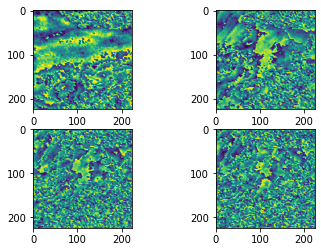

In [8]:
img,label = train_dataset[0]
if (label == 0):
  print("This is class nil")
elif (label == 1):
  print("This is class MOD")
else:
  print("This is class SEV")
print(img.shape)
Band8 = img[0][:][:]
Band12 = img[1][:][:]
Band13 = img[2][:][:]
Band14 = img[3][:][:]
Band = [Band8,Band12,Band13,Band14]
print(Band8)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.imshow(Band[i-1])
plt.show()


In [9]:
# #Calculate the number of samples in differnet class
# train_nil_count = 0   ##591
# train_MOD_count = 0   ##839
# train_SEV_count = 0   ##324
# valid_nil_count = 0   ##192
# valid_MOD_count = 0   ##81
# valid_SEV_count = 0   ##33

# for i in range (0,1754):
#     #print(i)
#     img, label = train_dataset[i]
#     if (label == 0):
#         train_nil_count += 1
#     elif (label == 1):
#         train_MOD_count += 1
#     else:
#         train_SEV_count += 1
# print("train set has %d nil, %d MOD, %d SEV" %(train_nil_count, train_MOD_count, train_SEV_count))

# for i in range (0,306):
#     #print(i)
#     img, label = val_dataset[i]
#     if (label == 0):
#         valid_nil_count += 1
#     elif (label == 1):
#         valid_MOD_count += 1
#     else:
#         valid_SEV_count += 1
# print("valid set has %d nil, %d MOD, %d SEV" %(valid_nil_count, valid_MOD_count, valid_SEV_count))

## Define Model & Loss 

### Resnet Model

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, pin_memory=False)

In [11]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
fc_features = model.fc.in_features
model.fc = nn.Linear(fc_features, 3)
model.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### LDAM Loss

In [12]:
def LDAMLoss(output, target, n_class_nil, n_class_MOD, n_class_SEV, C):
      loss = 0
      n_class = [n_class_nil, n_class_MOD, n_class_SEV]
      #output_class = output.argmax(dim=1, keepdim=False) #Shape [64], the predict class
      niter = output.shape[0] # 64 for a batch
      for i in range(niter):

          Z_y = output[i][target[i]]
          delta_y = C / (n_class[target[i]] ** (0.25) )
          nominator = torch.exp(Z_y - delta_y)
          if (target[i] == 0):
              dinominator = nominator + torch.exp(output[i][1]) + torch.exp(output[i][2])
          elif (target[i] == 1):
              dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][2])
          else:
              dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][1])
          loss += (-torch.log(nominator/dinominator))
      return loss



## Evaluation Function

In [13]:
def compute_acc(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=True)
    return preds.eq(targets.view_as(preds)).sum().item() / targets.shape[0]

In [14]:
def performance_eval(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=False)
    targets = targets.view_as(preds)
    performance_dict = {"NIL":0.0,"MOD":0.0, "SEV":0.0 }
    for i in range(3):
        TP = targets[preds.eq(i)].eq(i).sum().item()
        FP = (~targets[preds.eq(i)].eq(i)).sum().item()
        FN = (~preds[targets.eq(i)].eq(i)).sum().item()
        Precision =  torch.true_divide(TP,(TP + FP))
        Recall = torch.true_divide(TP,(TP + FN))
        F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
        performance_dict[list(performance_dict.keys())[i]] = torch.tensor([Precision,Recall,F1])
    return performance_dict

In [15]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        self.TP = torch.tensor([0,0,0])
        self.FP = torch.tensor([0,0,0])
        self.FN = torch.tensor([0,0,0])
        
    def update(self, val, outputs, targets, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        preds = outputs.argmax(dim=1, keepdim=True)
        preds = preds.view(-1)
        targets = targets.view(-1)
        for i in range(3):
            self.TP[i] += targets[preds.eq(i)].eq(i).sum().item()
            self.FP[i] += (~targets[preds.eq(i)].eq(i)).sum().item()
            self.FN[i] += (~preds[targets.eq(i)].eq(i)).sum().item()

In [16]:
model = model.cuda()
#optimizer = torch.optim.SGD(model.parameters(),lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [17]:
def train_one_epoch():
    accs = AverageMeter()

    for X, y in tqdm(train_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        #inputs = X
        #targets = y
        optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        #loss = criterion(outputs, targets)
        loss = LDAMLoss(outputs,targets,591,839,324,C = 2.0)
        
        loss.backward()
        optimizer.step()
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
        
    return accs ,loss
def validate_one_epoch():
    accs = AverageMeter()

    for X, y in tqdm(val_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        #inputs = X
        #targets = y
        #optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        #loss = criterion(outputs, targets)
        loss = LDAMLoss(outputs,targets,192,81,33,C = 2.0)

        #loss.backward()
        #optimizer.step()
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
    return accs , loss

In [18]:
best_epoch = -1
best_acc = 0.0
history_acc = []
history_acc_2 = []
best_model_state = model.state_dict()
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
train_loss = 0
valid_loss = 0
for epoch in tqdm(range(20)):
    for phase in range (0,2):
      if phase == 0:
        model.train()
        accs ,train_loss= train_one_epoch()
        print("epoch {} train acc: {:.4f} ".format(epoch, accs.avg))
        class_names = ["NIL","MOD","SEV"]
        for i in range(3):
            Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
            Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
            F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
            #wandb.log({"train_acc":accs.avg,"train_loss": train_loss, "train_precision": Precision,"train_recall": Recall,"train_f1":F1}, step = epoch)
            print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
        history_acc.append(accs)
        scheduler.step()

      elif phase == 1:
          model.eval()
          accs ,valid_loss = validate_one_epoch()
          print("epoch {} valid acc: {:.4f} ".format(epoch, accs.avg))
          class_names = ["NIL","MOD","SEV"]
          for i in range(3):
            Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
            Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
            F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
            #wandb.log({"valid_acc":accs.avg,"valid_loss": valid_loss, "valid_precision": Precision,"valid_recall": Recall,"valid_f1":F1}, step = epoch)

            print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
            #history_acc.append(accs)  
          if accs.avg > best_acc:
            best_acc = accs.avg
            best_epoch = epoch
            best_model_state = model.state_dict()                  
          history_acc_2.append(accs)

print(f'[Info] best val acc: {best_acc:.2%} at {best_epoch+1}th epoch')



epoch 0 train acc: 0.5650 
class NIL Precision 0.645 Recall0.452 F1 0.531
class MOD Precision 0.545 Recall0.856 F1 0.666
class SEV Precision 0.261 Recall0.019 F1 0.035


epoch 0 valid acc: 0.6275 
class NIL Precision 0.627 Recall1.000 F1 0.771
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 1 train acc: 0.6391 
class NIL Precision 0.770 Recall0.616 F1 0.684
class MOD Precision 0.605 Recall0.862 F1 0.711
class SEV Precision 0.400 Recall0.105 F1 0.166


epoch 1 valid acc: 0.6667 
class NIL Precision 0.890 Recall0.714 F1 0.792
class MOD Precision 0.441 Recall0.827 F1 0.575
class SEV Precision nan Recall0.000 F1 nan


epoch 2 train acc: 0.6767 
class NIL Precision 0.840 Recall0.682 F1 0.753
class MOD Precision 0.625 Recall0.892 F1 0.735
class SEV Precision 0.462 Recall0.111 F1 0.179


epoch 2 valid acc: 0.3922 
class NIL Precision 1.000 Recall0.203 F1 0.338
class MOD Precision 0.303 Recall1.000 F1 0.466
class SEV Precision nan Recall0.000 F1 nan


epoch 3 train acc: 0.7013 
class NIL Precision 0.851 Recall0.694 F1 0.764
class MOD Precision 0.651 Recall0.887 F1 0.751
class SEV Precision 0.589 Recall0.235 F1 0.336


epoch 3 valid acc: 0.6275 
class NIL Precision 0.627 Recall1.000 F1 0.771
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 4 train acc: 0.7605 
class NIL Precision 0.858 Recall0.745 F1 0.797
class MOD Precision 0.725 Recall0.867 F1 0.789
class SEV Precision 0.702 Recall0.515 F1 0.594


epoch 4 valid acc: 0.4739 
class NIL Precision 0.695 Recall0.510 F1 0.589
class MOD Precision 0.294 Recall0.580 F1 0.390
class SEV Precision 0.000 Recall0.000 F1 nan


epoch 5 train acc: 0.8620 
class NIL Precision 0.877 Recall0.893 F1 0.885
class MOD Precision 0.882 Recall0.861 F1 0.871
class SEV Precision 0.787 Recall0.809 F1 0.798


epoch 5 valid acc: 0.6830 
class NIL Precision 1.000 Recall0.625 F1 0.769
class MOD Precision 0.461 Recall0.951 F1 0.621
class SEV Precision 0.632 Recall0.364 F1 0.462


epoch 6 train acc: 0.9287 
class NIL Precision 0.954 Recall0.944 F1 0.949
class MOD Precision 0.904 Recall0.968 F1 0.935
class SEV Precision 0.956 Recall0.799 F1 0.871


epoch 6 valid acc: 0.7255 
class NIL Precision 0.748 Recall0.927 F1 0.828
class MOD Precision 0.702 Recall0.407 F1 0.516
class SEV Precision 0.524 Recall0.333 F1 0.407


epoch 7 train acc: 0.9686 
class NIL Precision 0.986 Recall0.983 F1 0.985
class MOD Precision 0.976 Recall0.967 F1 0.971
class SEV Precision 0.919 Recall0.948 F1 0.933


epoch 7 valid acc: 0.8235 
class NIL Precision 0.963 Recall0.818 F1 0.885
class MOD Precision 0.642 Recall0.951 F1 0.766
class SEV Precision 0.783 Recall0.545 F1 0.643


epoch 8 train acc: 0.9869 
class NIL Precision 0.993 Recall0.993 F1 0.993
class MOD Precision 0.986 Recall0.987 F1 0.986
class SEV Precision 0.978 Recall0.975 F1 0.977


epoch 8 valid acc: 0.7745 
class NIL Precision 0.986 Recall0.750 F1 0.852
class MOD Precision 0.619 Recall0.864 F1 0.722
class SEV Precision 0.489 Recall0.697 F1 0.575


epoch 9 train acc: 0.9920 
class NIL Precision 0.993 Recall0.993 F1 0.993
class MOD Precision 0.992 Recall0.992 F1 0.992
class SEV Precision 0.991 Recall0.991 F1 0.991


epoch 9 valid acc: 0.8268 
class NIL Precision 0.942 Recall0.849 F1 0.893
class MOD Precision 0.683 Recall0.852 F1 0.758
class SEV Precision 0.656 Recall0.636 F1 0.646


epoch 10 train acc: 0.9954 
class NIL Precision 0.992 Recall1.000 F1 0.996
class MOD Precision 0.999 Recall0.992 F1 0.995
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 10 valid acc: 0.7974 
class NIL Precision 0.987 Recall0.792 F1 0.879
class MOD Precision 0.631 Recall0.864 F1 0.729
class SEV Precision 0.537 Recall0.667 F1 0.595


epoch 11 train acc: 0.9960 
class NIL Precision 0.998 Recall0.995 F1 0.997
class MOD Precision 0.995 Recall0.996 F1 0.996
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 11 valid acc: 0.8137 
class NIL Precision 0.987 Recall0.812 F1 0.891
class MOD Precision 0.634 Recall0.877 F1 0.736
class SEV Precision 0.611 Recall0.667 F1 0.638


epoch 12 train acc: 0.9954 
class NIL Precision 0.997 Recall1.000 F1 0.998
class MOD Precision 0.998 Recall0.993 F1 0.995
class SEV Precision 0.988 Recall0.994 F1 0.991


epoch 12 valid acc: 0.7778 
class NIL Precision 0.986 Recall0.755 F1 0.855
class MOD Precision 0.587 Recall0.877 F1 0.703
class SEV Precision 0.579 Recall0.667 F1 0.620


epoch 13 train acc: 0.9977 
class NIL Precision 0.997 Recall0.998 F1 0.997
class MOD Precision 0.998 Recall0.999 F1 0.998
class SEV Precision 1.000 Recall0.994 F1 0.997


epoch 13 valid acc: 0.7941 
class NIL Precision 0.987 Recall0.781 F1 0.872
class MOD Precision 0.607 Recall0.877 F1 0.717
class SEV Precision 0.595 Recall0.667 F1 0.629


epoch 14 train acc: 0.9971 
class NIL Precision 0.998 Recall0.998 F1 0.998
class MOD Precision 0.995 Recall0.999 F1 0.997
class SEV Precision 1.000 Recall0.991 F1 0.995


epoch 14 valid acc: 0.8039 
class NIL Precision 0.981 Recall0.797 F1 0.879
class MOD Precision 0.623 Recall0.877 F1 0.728
class SEV Precision 0.611 Recall0.667 F1 0.638


epoch 15 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall1.000 F1 0.997


epoch 15 valid acc: 0.7974 
class NIL Precision 0.987 Recall0.786 F1 0.875
class MOD Precision 0.607 Recall0.877 F1 0.717
class SEV Precision 0.611 Recall0.667 F1 0.638


epoch 16 train acc: 0.9971 
class NIL Precision 0.997 Recall1.000 F1 0.998
class MOD Precision 0.998 Recall0.998 F1 0.998
class SEV Precision 0.997 Recall0.991 F1 0.994


epoch 16 valid acc: 0.7974 
class NIL Precision 0.987 Recall0.781 F1 0.872
class MOD Precision 0.600 Recall0.889 F1 0.716
class SEV Precision 0.647 Recall0.667 F1 0.657


epoch 17 train acc: 0.9966 
class NIL Precision 0.998 Recall0.997 F1 0.997
class MOD Precision 0.998 Recall0.996 F1 0.997
class SEV Precision 0.991 Recall0.997 F1 0.994


epoch 17 valid acc: 0.7647 
class NIL Precision 0.986 Recall0.734 F1 0.842
class MOD Precision 0.597 Recall0.877 F1 0.710
class SEV Precision 0.500 Recall0.667 F1 0.571


epoch 18 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 18 valid acc: 0.7974 
class NIL Precision 0.987 Recall0.786 F1 0.875
class MOD Precision 0.607 Recall0.877 F1 0.717
class SEV Precision 0.611 Recall0.667 F1 0.638


epoch 19 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.998 F1 0.998
class SEV Precision 0.997 Recall0.997 F1 0.997


epoch 19 valid acc: 0.7974 
class NIL Precision 0.987 Recall0.786 F1 0.875
class MOD Precision 0.640 Recall0.877 F1 0.740
class SEV Precision 0.524 Recall0.667 F1 0.587

[Info] best val acc: 82.68% at 10th epoch


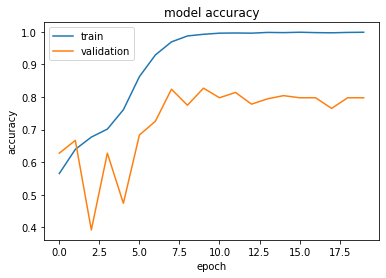

In [23]:
accuracy = []
accuracy_2 = []

for accs in history_acc:
    accuracy.append(accs.avg)
for accs in history_acc_2:
    accuracy_2.append(accs.avg)
plt.plot(range(20),accuracy)
plt.plot(range(20),accuracy_2)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [24]:
torch.save(best_model_state, "Final_model_state.tar")


In [25]:
model.eval()
for X, y in tqdm(val_loader, leave=False):
    inputs = X.cuda()
    outputs = model(inputs)
    print("y actual:",y)
    print(outputs.argmax(dim=1, keepdim=True).view(-1))
    acc = compute_acc(outputs.cpu(), y)
    print(f'Test Acc: {acc}')

y actual: tensor([0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 2, 2, 1, 0, 0, 0, 2, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 2])
tensor([1, 1, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 2, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 2, 1, 2, 0, 0, 0, 1, 2, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 2, 1, 2], device='cuda:0')
Test Acc: 0.78125
y actual: tensor([1, 0, 0, 2, 1, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 2, 1, 0, 1, 0,
        1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2])
tensor([1, 0, 0, 2, 2, 0, 0, 2, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 2, 1, 2, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 2, 1, 0, 2, 0,
        1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 1, 1], device='cuda:0')
Test Acc: 0.71875
y actual: tensor([0, 0, 0, 1, 0, 0, 0, 0, 

In [21]:
print(outputs.shape[0])
output_class = outputs.argmax(dim=1, keepdim=False)
print(output_class)

50
tensor([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 2, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 1, 2, 1,
        2, 0], device='cuda:0')


In [26]:
def final_evaluation():
    model.eval()
    accs = AverageMeter()
    for X, y in tqdm(train_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        outputs = model(inputs)
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
    print("train acc: {:.4f} ".format(accs.avg))
    class_names = ["NIL","MOD","SEV"]
    for i in range(3):
        Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
        Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
        F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
        print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
        
    accs = AverageMeter()
    for X, y in tqdm(val_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        outputs = model(inputs)
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
    print("validation acc: {:.4f} ".format(accs.avg))
    class_names = ["NIL","MOD","SEV"]
    for i in range(3):
        Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
        Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
        F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
        print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))

In [27]:
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [28]:
final_evaluation()

train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall1.000 F1 0.997


validation acc: 0.7974 
class NIL Precision 0.987 Recall0.786 F1 0.875
class MOD Precision 0.640 Recall0.877 F1 0.740
class SEV Precision 0.524 Recall0.667 F1 0.587


## Report
For our final model, the middle of our network is famous pretrained Resnet-18, we use it as feature extractor and we change the output of last fully-connected layer to 3 (Nil, MOD, SEV) and we modify the first convolution input layer to accept 4 channels.

***Same as Baseline 1& 2, We have to point out that WE HAVE TRIED the data processing with many techniques and transforms, but on the very last day we find it may not be suitable for this project. Because the accuracy with data-augmentation is way below the accuracy without it. Our conclusion is, the color and direction all matters for this task, we should not randomly flip or jitter the picture, otherwise it will confuse our model. If you do not believe it, you could just uncomment the transforms and run the model for comparison. So we comment nearly all the transforms but PLEASE NOTE we tried many times for this before.***

For this model, we use the network as stated above, and the loss function is LDAM loss which implemented in BASELINE 2, and the optimizer is Adam with learning rate `0.001` and lr-scheduler.

Given our tuning procedure of BASELINE 1 & 2, it is quite simple for us to apply these experiences in this final model. After finishing designing our model. we begin with same hyper-parameter with BASELINE 2.(C = 1.0 and lr = 0.001 with scheduler). We see that the convergence trend is clear and the validation accuracy is not high enough, thus there is no need for us to change lr but turning C is needed. We test C from` [0.01,0.05,0.1,0.5,1.0,2.0,5.0,10.0]` and find that C=2 has the best performance for this resnet model.

For the precision, recall, and F1 score, We use a function to calculate that, you could see the results above in the output box.

We actually output all the information at each epoch so you could also refer to that.

So this is our report for final model. 